# LSST CCOB ghost analysis

Develop the ghost images analysis

## TODO
- design a real image analysis to get a list of ghost spots
- update distance between 2 ghost spots to consider flux and size

## Notes
- for each optical element: 3 rotations, 3 positions
- L1, L2, L3, Filter, Detector, Beam: 6 x 6 = 36 parameters


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batoid
import ghosts.plotter as plotter
import ghosts.simulator as simulator
import ghosts.tweak_optics as tweak_optics

from ghosts.analysis import compute_ghost_separations
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_1, BEAM_CONFIG_2, FAST_BEAM_CONFIG_1



In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 9000 pixels per mm^2


In [4]:
# CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

In [5]:
# test list of optics
assert tweak_optics.get_list_of_optics(telescope)==['L1', 'L2', 'L3', 'Detector'], 'Not a CCOB optical setup'

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(telescope)


0

Direct path is number 15
  central impact point is (0.100364, 0.000397)
  transmission is 0.8681

Maximum expected flux is 0.8681
Maximum bin content is 361.2343


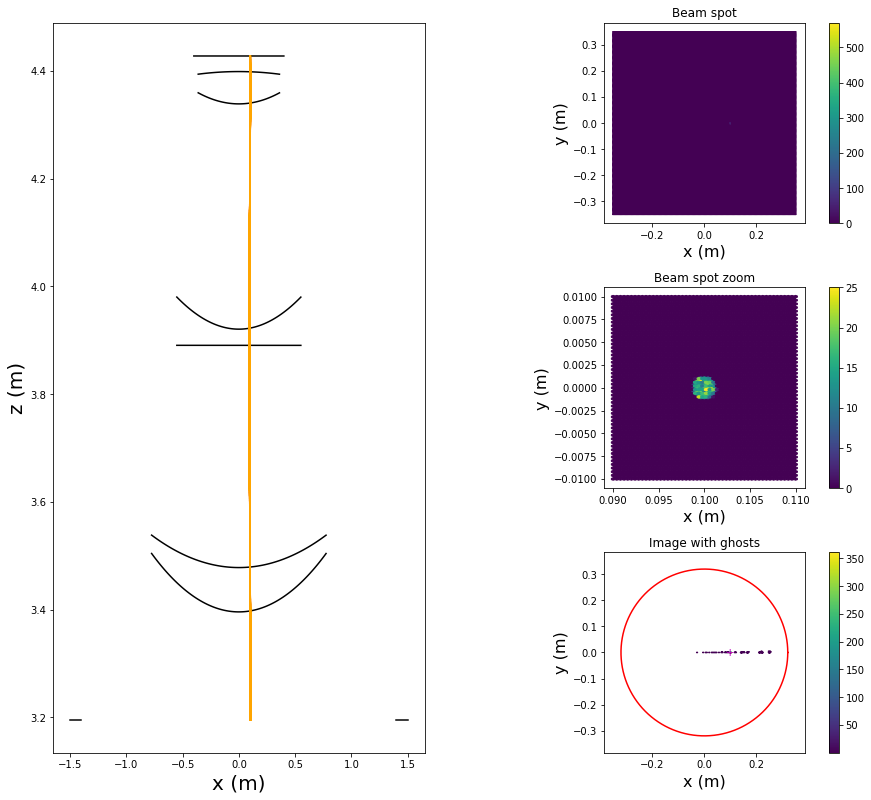

0

In [6]:
# Run simulation with standard beam config
traceFull, rForward, rReverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_1)
simulation = [traceFull, rForward, rReverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)


(<Figure size 1296x648 with 3 Axes>,
 array([<AxesSubplot: title={'center': 'Beam spot'}>,
        <AxesSubplot: title={'center': 'Projection of ghosts image on the x-axis'}, xlabel='position x (m)', ylabel='~n photons'>,
        <AxesSubplot: title={'center': 'Projection of ghosts image on the y-axis'}, xlabel='position y (m)', ylabel='~n photons'>],
       dtype=object))

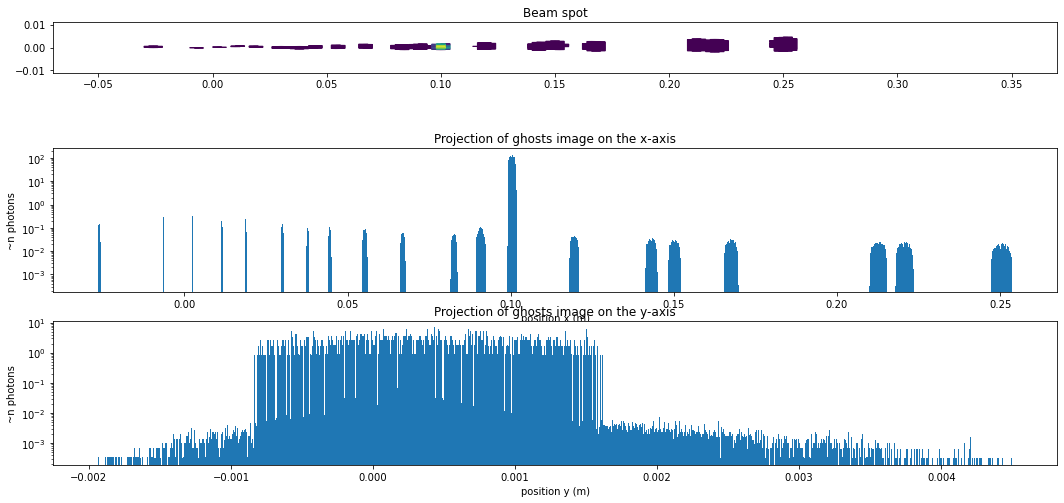

In [7]:
# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


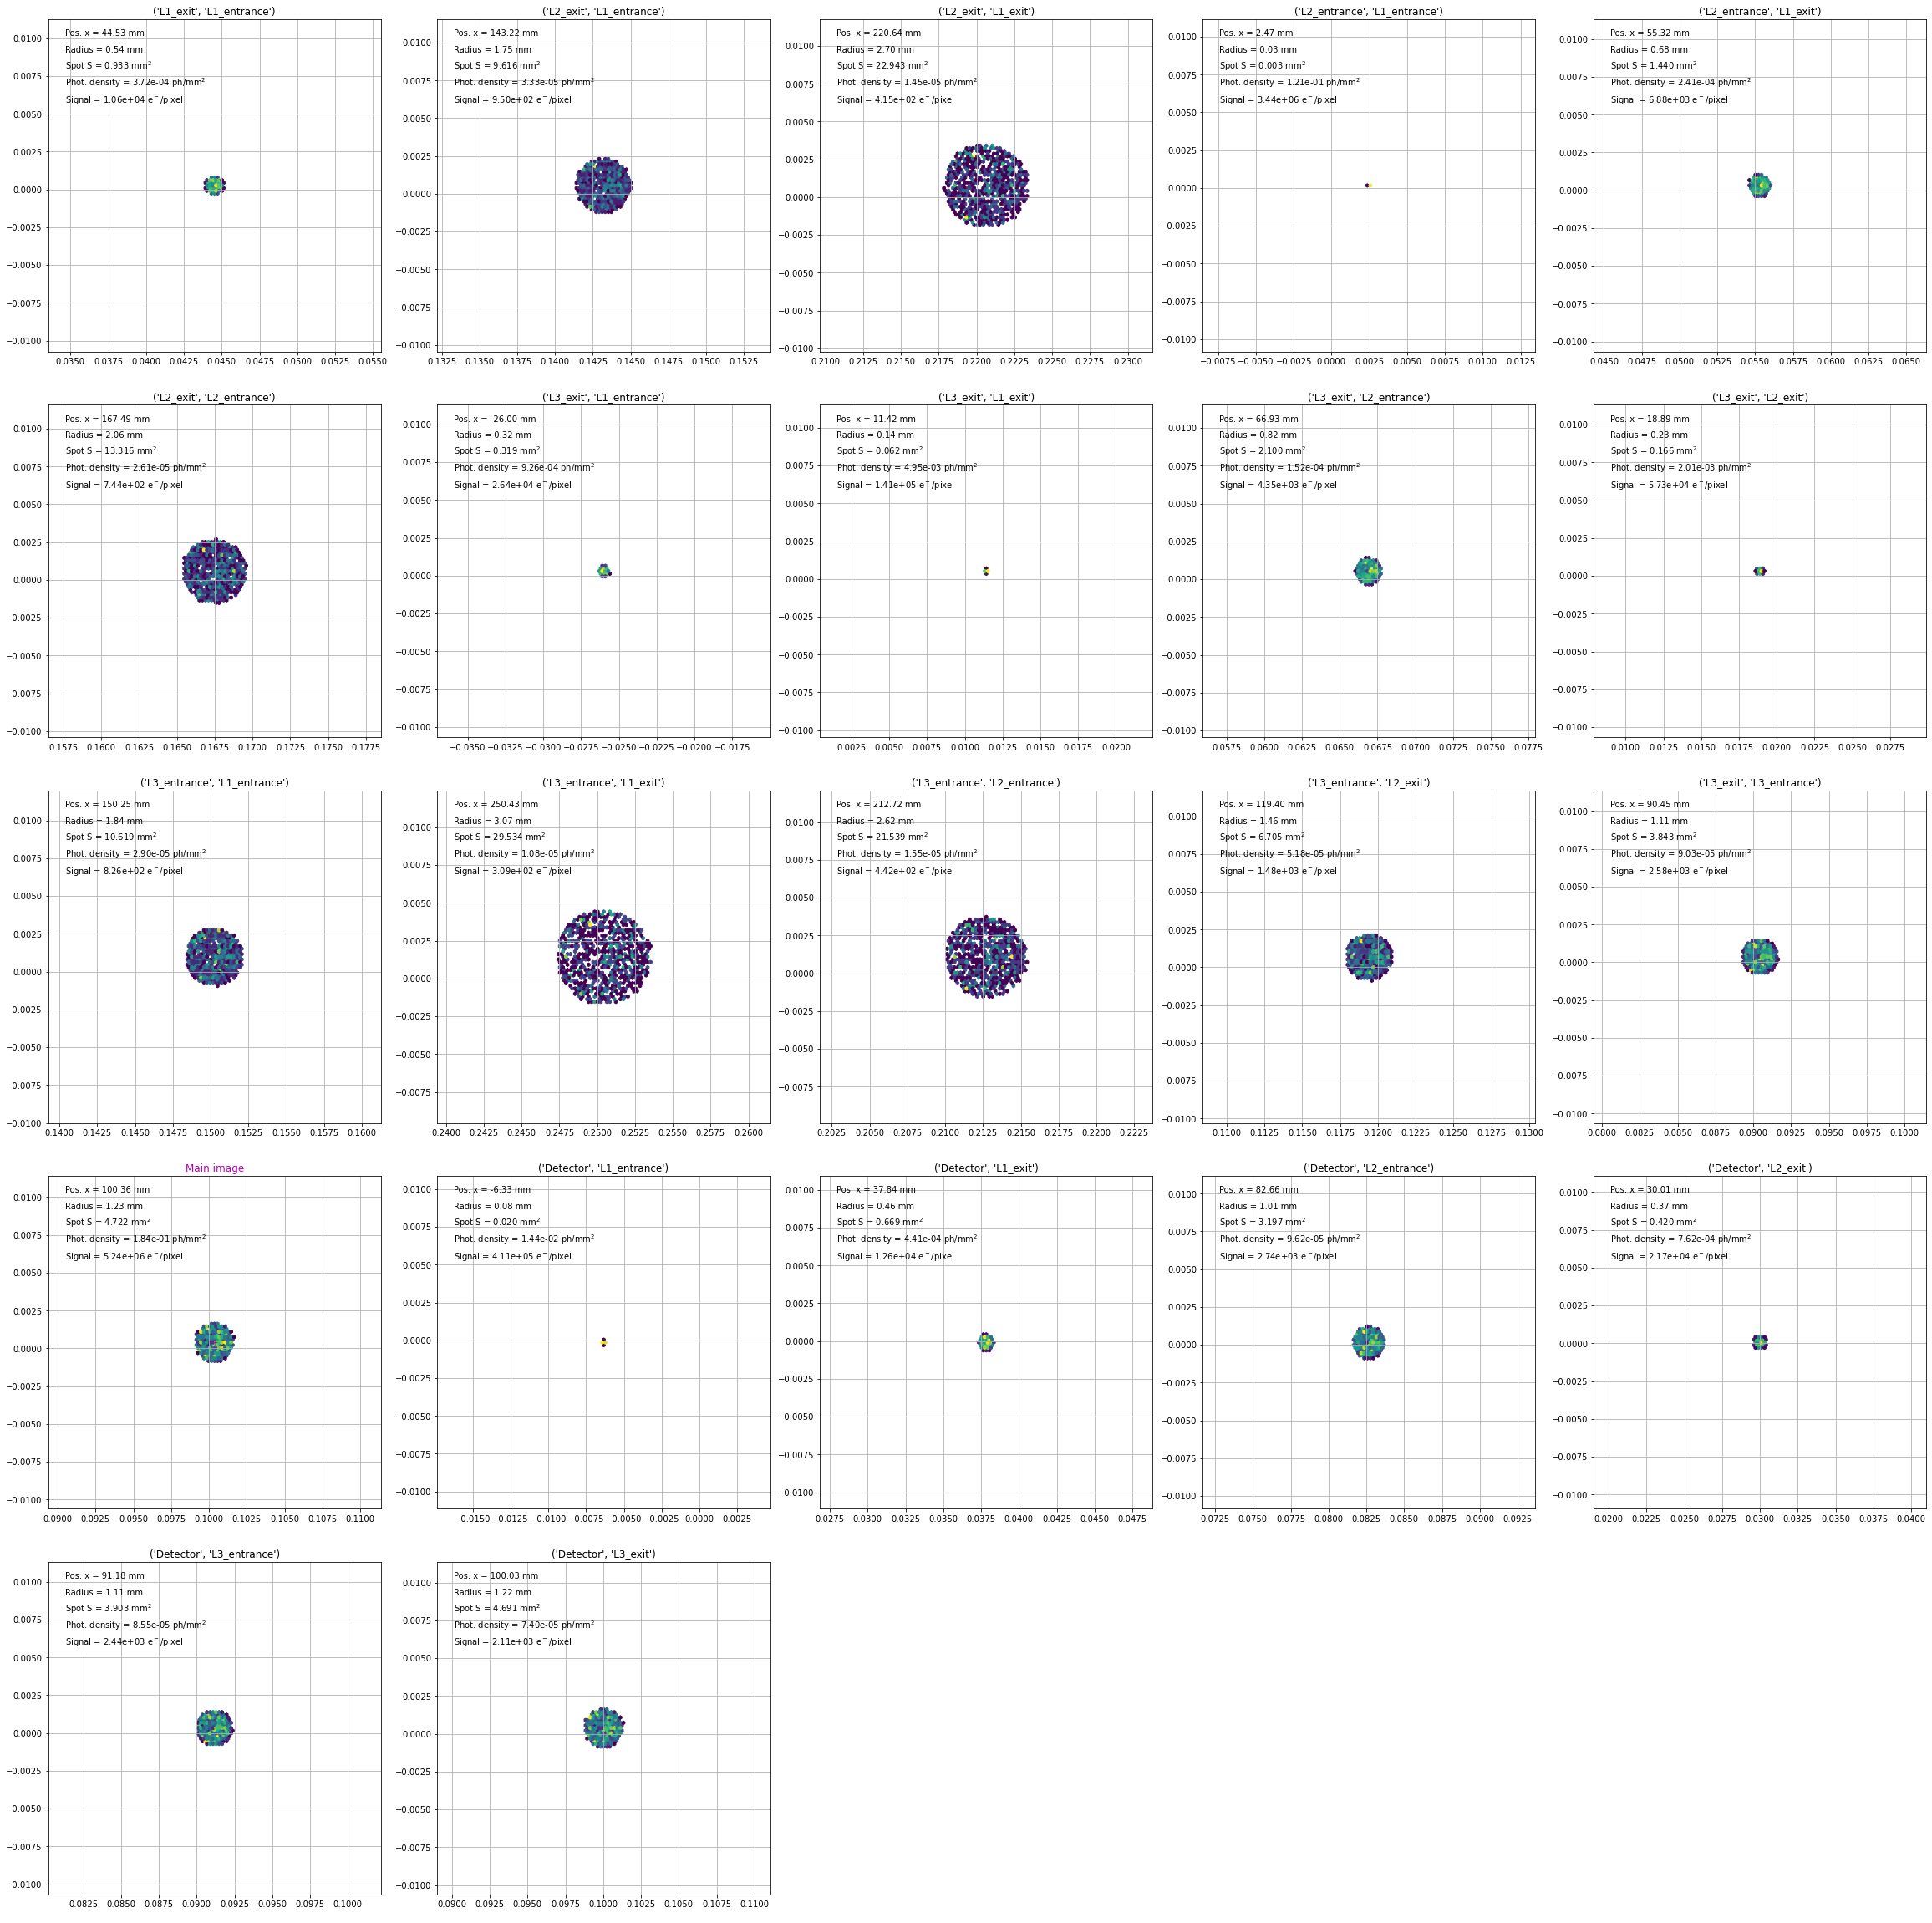

In [8]:
# make figure and fill with plots
plt.rcParams["figure.figsize"] = [24, 24]
spots_data = plotter.plot_ghosts_map(rForward)

In [9]:
data_frame_1 = make_data_frame(spots_data, BEAM_CONFIG_1['beam_id'])
data_frame_1.sort_values(by=['name'])

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,n_pixels,pixel_signal
16,1,0,16,"(Detector, L1_entrance)",-0.006333,0.000041,-0.000138,0.000041,0.000162,0.000154,0.000079,3.970470e-06,0.283729,0.019680,177,4.112797e+05
17,1,0,17,"(Detector, L1_exit)",0.037845,0.000231,-0.000086,0.000231,0.000921,0.000926,0.000462,2.653115e-06,0.295428,0.669421,6025,1.258934e+04
18,1,0,18,"(Detector, L2_entrance)",0.082663,0.000506,0.000160,0.000506,0.002013,0.002022,0.001009,4.304214e-06,0.307609,3.197000,28773,2.744779e+03
19,1,0,19,"(Detector, L2_exit)",0.030006,0.000183,0.000060,0.000183,0.000729,0.000734,0.000366,2.880516e-06,0.320293,0.420188,3782,2.174474e+04
20,1,0,20,"(Detector, L3_entrance)",0.091177,0.000560,0.000331,0.000560,0.002228,0.002230,0.001115,9.018228e-07,0.333499,3.902734,35125,2.437680e+03
21,1,0,21,"(Detector, L3_exit)",0.100035,0.000614,0.000382,0.000614,0.002441,0.002447,0.001222,2.945131e-06,0.347250,4.690540,42215,2.111887e+03
0,1,0,0,"(L1_exit, L1_entrance)",0.044527,0.000274,0.000262,0.000274,0.001089,0.001090,0.000545,6.711404e-07,0.347250,0.932692,8394,1.062075e+04
3,1,0,3,"(L2_entrance, L1_entrance)",0.002468,0.000014,0.000164,0.000014,0.000056,0.000063,0.000030,3.426943e-06,0.333499,0.002767,25,3.438151e+06
4,1,0,4,"(L2_entrance, L1_exit)",0.055319,0.000340,0.000318,0.000340,0.001353,0.001355,0.000677,9.933229e-07,0.347250,1.439857,12959,6.879772e+03
1,1,0,1,"(L2_exit, L1_entrance)",0.143221,0.000879,0.000551,0.000879,0.003495,0.003503,0.001750,4.344837e-06,0.320293,9.616174,86546,9.501571e+02


Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


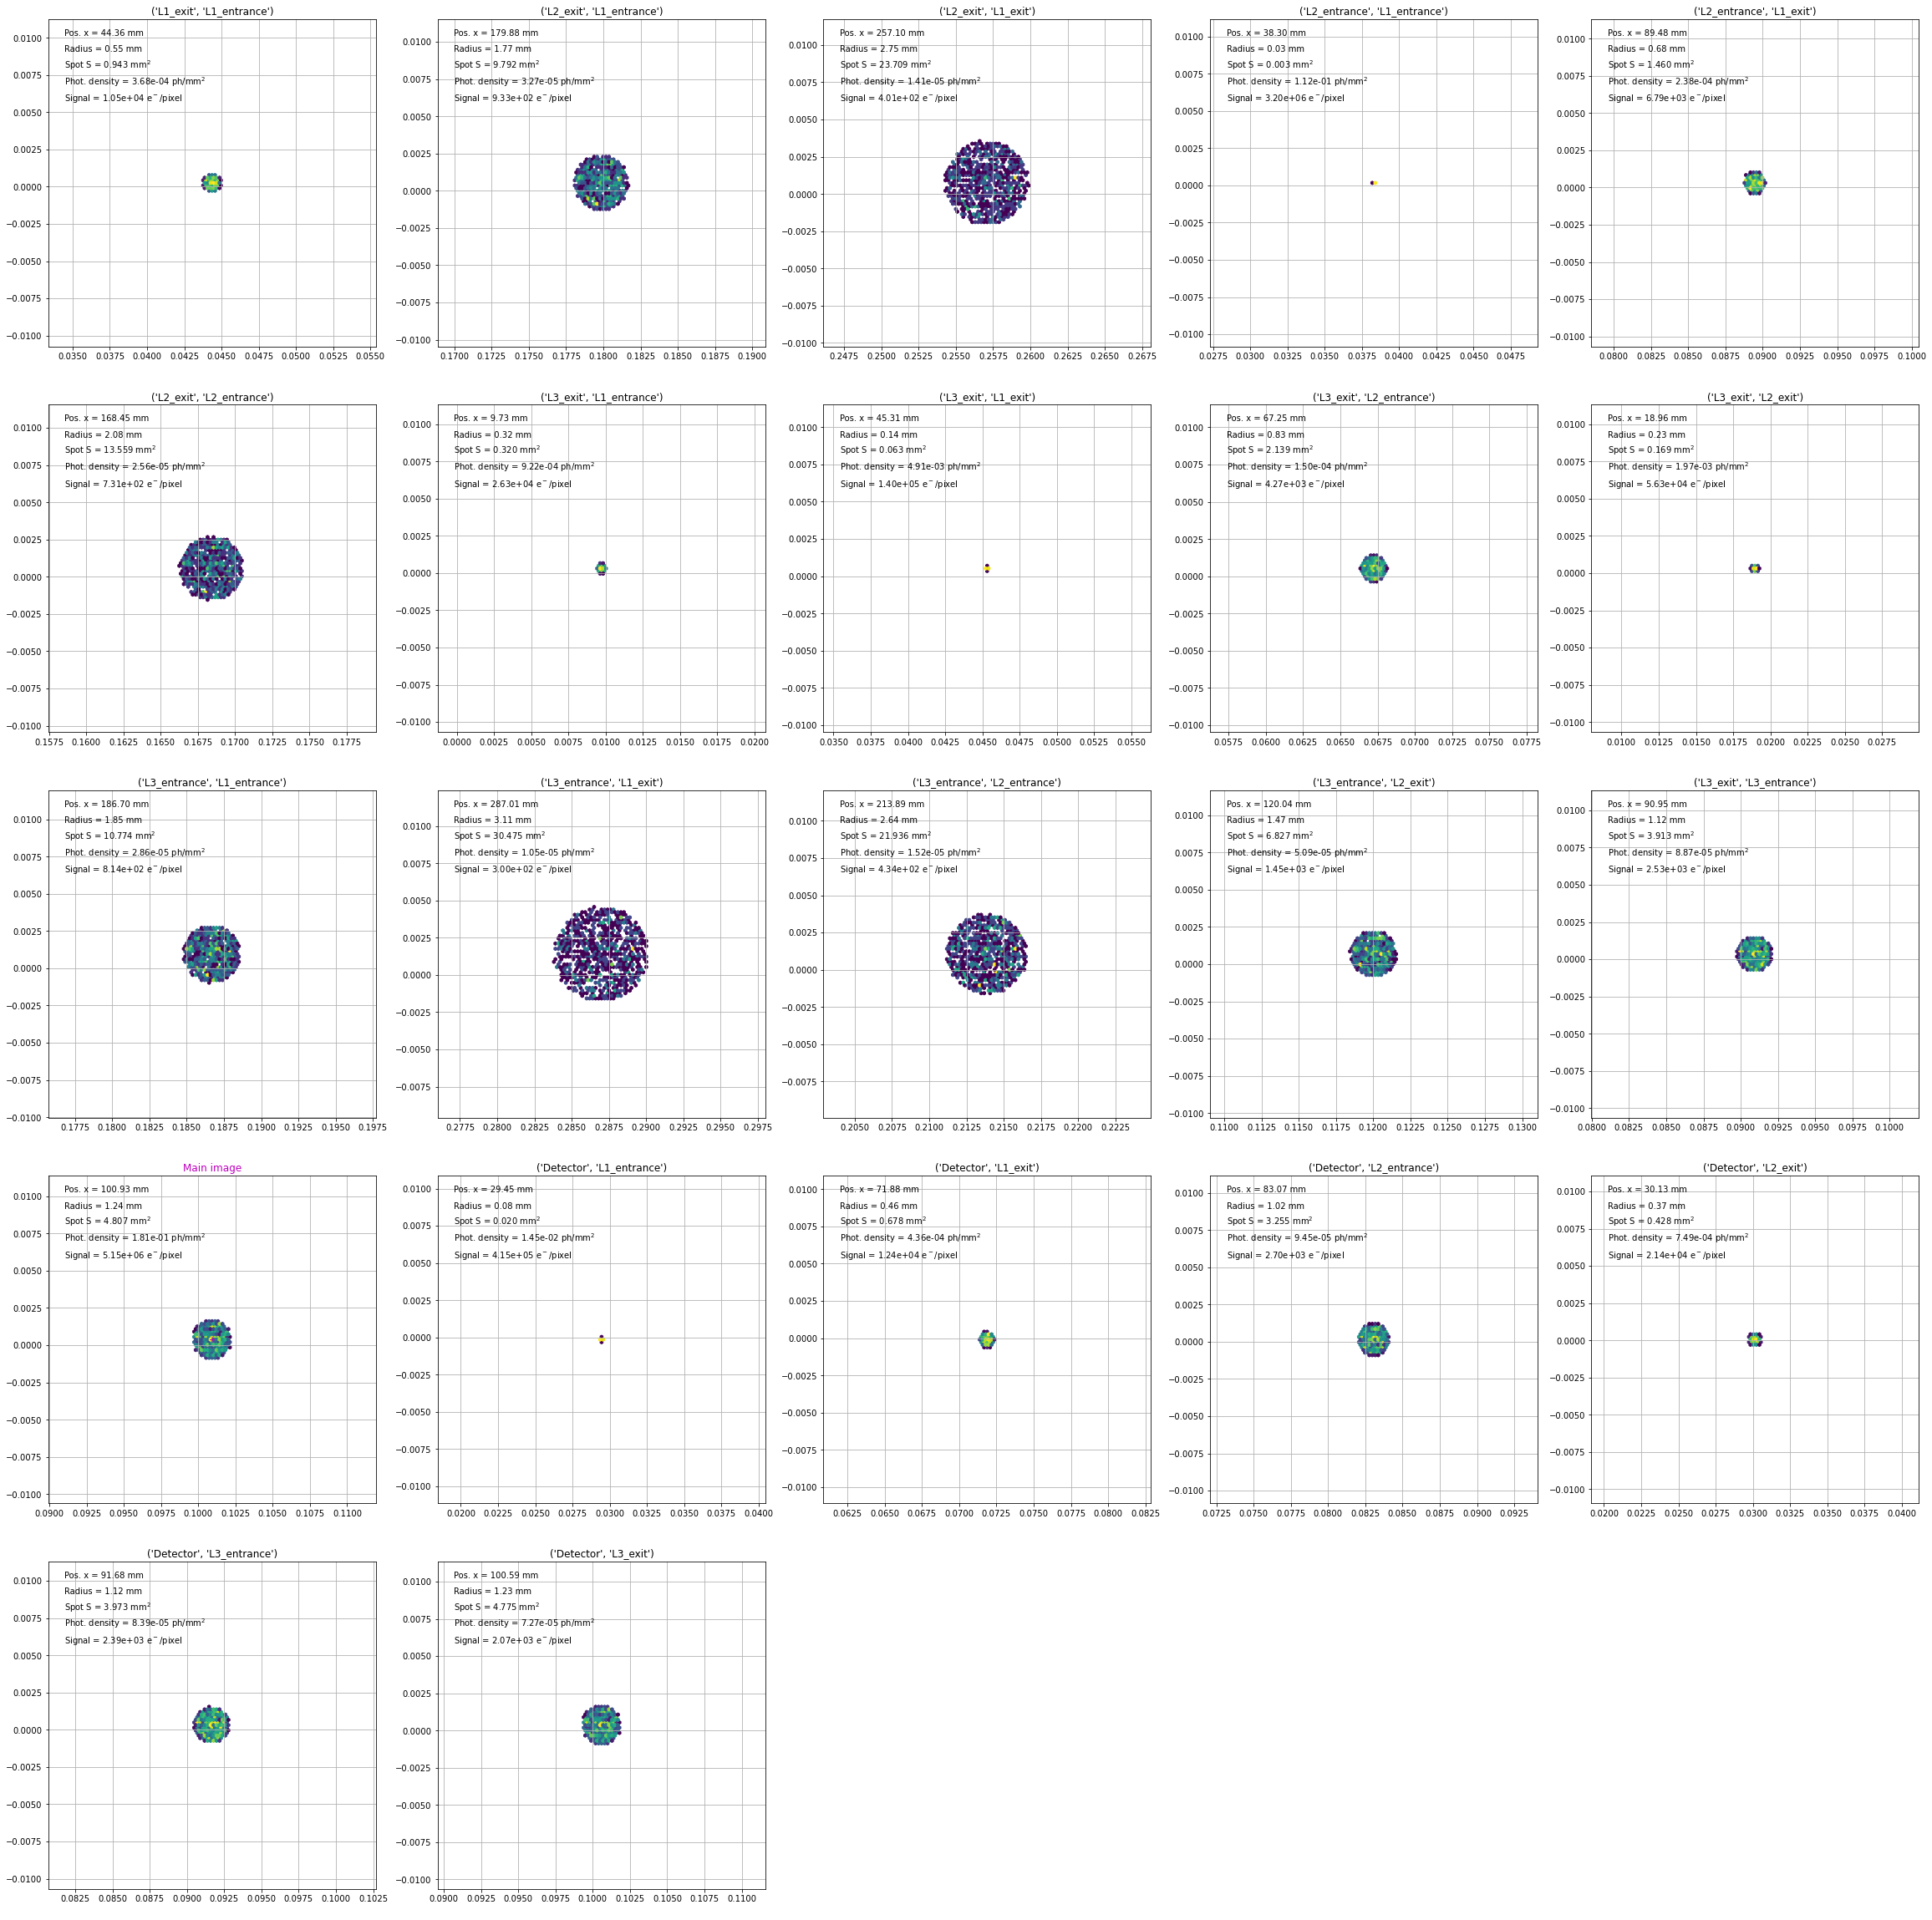

In [10]:
# Run another simulation with rotated L1
rotated_telescope = tweak_optics.rotate_optic(telescope, 'L1', axis='y', angle=1)
tweak_optics.make_optics_reflective(rotated_telescope)

traceFull_2, rForward_2, rReverse_2, rays_2 = simulator.run_simulation(rotated_telescope,
                                                                       beam_config=BEAM_CONFIG_1)
plt.rcParams["figure.figsize"] = [24, 24]
spots_data_2 = plotter.plot_ghosts_map(rForward_2)


In [11]:
data_frame_2 = make_data_frame(spots_data_2, BEAM_CONFIG_1['beam_id'])
data_frame_2.sort_values(by=['name'])

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,n_pixels,pixel_signal
16,1,0,16,"(Detector, L1_entrance)",0.029450,0.000040,-0.000137,0.000040,0.000161,0.000154,0.000079,3.127526e-06,0.283729,0.019505,176,4.149579e+05
17,1,0,17,"(Detector, L1_exit)",0.071876,0.000229,-0.000093,0.000229,0.000929,0.000929,0.000465,1.672495e-08,0.295428,0.678234,6104,1.242575e+04
18,1,0,18,"(Detector, L2_entrance)",0.083070,0.000501,0.000147,0.000501,0.002039,0.002033,0.001018,2.974983e-06,0.307609,3.255292,29298,2.695628e+03
19,1,0,19,"(Detector, L2_exit)",0.030135,0.000181,0.000055,0.000181,0.000738,0.000738,0.000369,2.371554e-07,0.320293,0.427897,3851,2.135296e+04
20,1,0,20,"(Detector, L3_entrance)",0.091684,0.000555,0.000317,0.000555,0.002256,0.002242,0.001125,7.114162e-06,0.333499,3.973353,35760,2.394354e+03
21,1,0,21,"(Detector, L3_exit)",0.100593,0.000608,0.000366,0.000608,0.002472,0.002460,0.001233,5.792301e-06,0.347250,4.775179,42977,2.074454e+03
0,1,0,0,"(L1_exit, L1_entrance)",0.044363,0.000270,0.000255,0.000270,0.001097,0.001094,0.000548,1.444448e-06,0.347250,0.942688,8484,1.050813e+04
3,1,0,3,"(L2_entrance, L1_entrance)",0.038297,0.000015,0.000164,0.000015,0.000060,0.000063,0.000031,1.943533e-06,0.333499,0.002970,27,3.202943e+06
4,1,0,4,"(L2_entrance, L1_exit)",0.089478,0.000336,0.000309,0.000336,0.001366,0.001360,0.000682,2.922960e-06,0.347250,1.459518,13136,6.787098e+03
1,1,0,1,"(L2_exit, L1_entrance)",0.179882,0.000870,0.000530,0.000870,0.003537,0.003525,0.001765,5.827685e-06,0.320293,9.791853,88127,9.331101e+02


In [12]:
match_1_2 = match_ghosts(data_frame_1, data_frame_2)
match_1_2

,beam_id_1,geom_id_1,beam_id_2,geom_id_2,ghost_1,ghost_2_2d,distance_2d,distance_2d_err,ghost_2_3d,distance_3d,distance_3d_err
0,1,0,1,0,0,0,0.000165,0.000544,0,0.000335,0.000567
1,1,0,1,0,1,13,0.023183,0.001613,13,0.036002,0.001919
2,1,0,1,0,2,12,0.006759,0.002674,12,0.009035,0.005773
3,1,0,1,0,3,6,0.007261,0.000225,9,0.026102,0.000502
4,1,0,1,0,4,7,0.010008,0.000491,0,0.016941,0.000639
5,1,0,1,0,5,5,0.000967,0.002072,5,0.002111,0.004774
6,1,0,1,0,6,6,0.035731,0.000320,6,0.035731,0.000889
7,1,0,1,0,7,6,0.001707,0.000245,9,0.011845,0.000526
8,1,0,1,0,8,8,0.000322,0.000816,8,0.000809,0.000957
9,1,0,1,0,9,9,0.000067,0.000228,9,0.000220,0.000634


In [13]:
compute_reduced_distance(match_1_2)

0.0037203084345353156

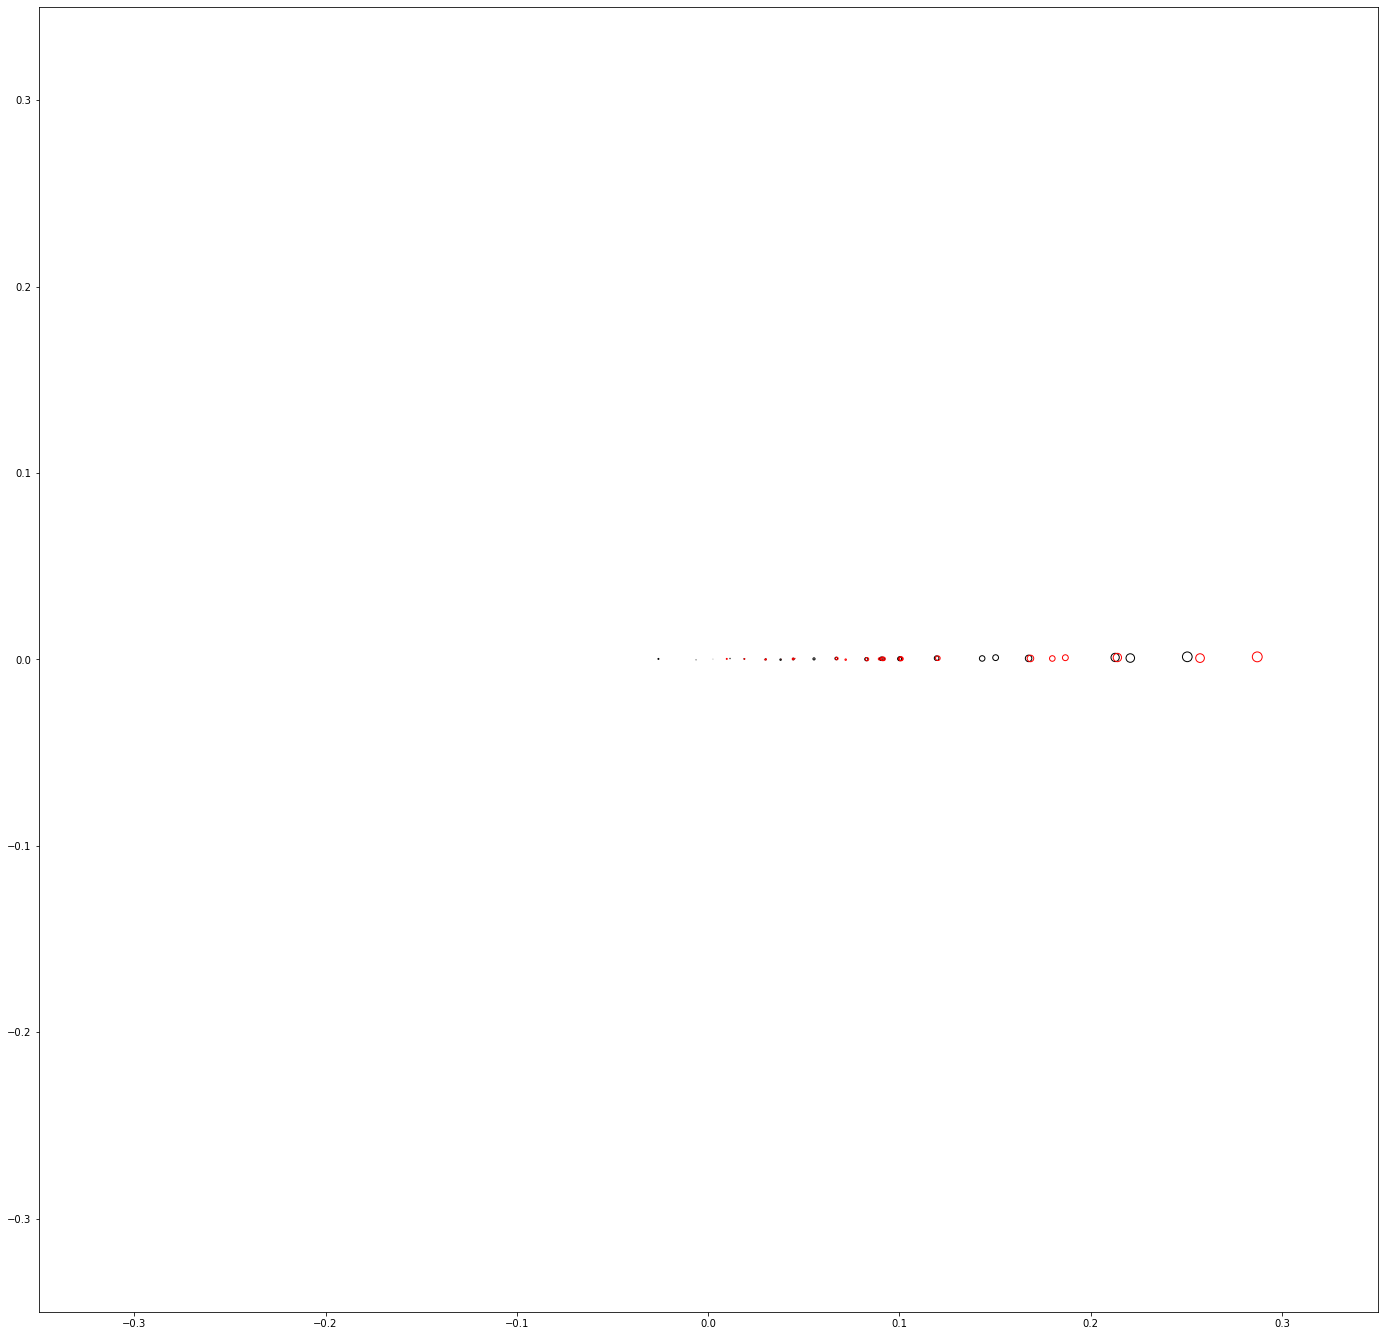

In [14]:
fig, ax = plotter.plot_spots([data_frame_1, data_frame_2])

In [15]:
# See what happens with a random telescope
data_frame_r, ghost_separations_r = simulator.full_random_telescope_sim(telescope,\
                                    max_angle=1, max_shift=0.001, beam_config=BEAM_CONFIG_1)


distance 3d = 0.00517
distance 2d = 0.00340


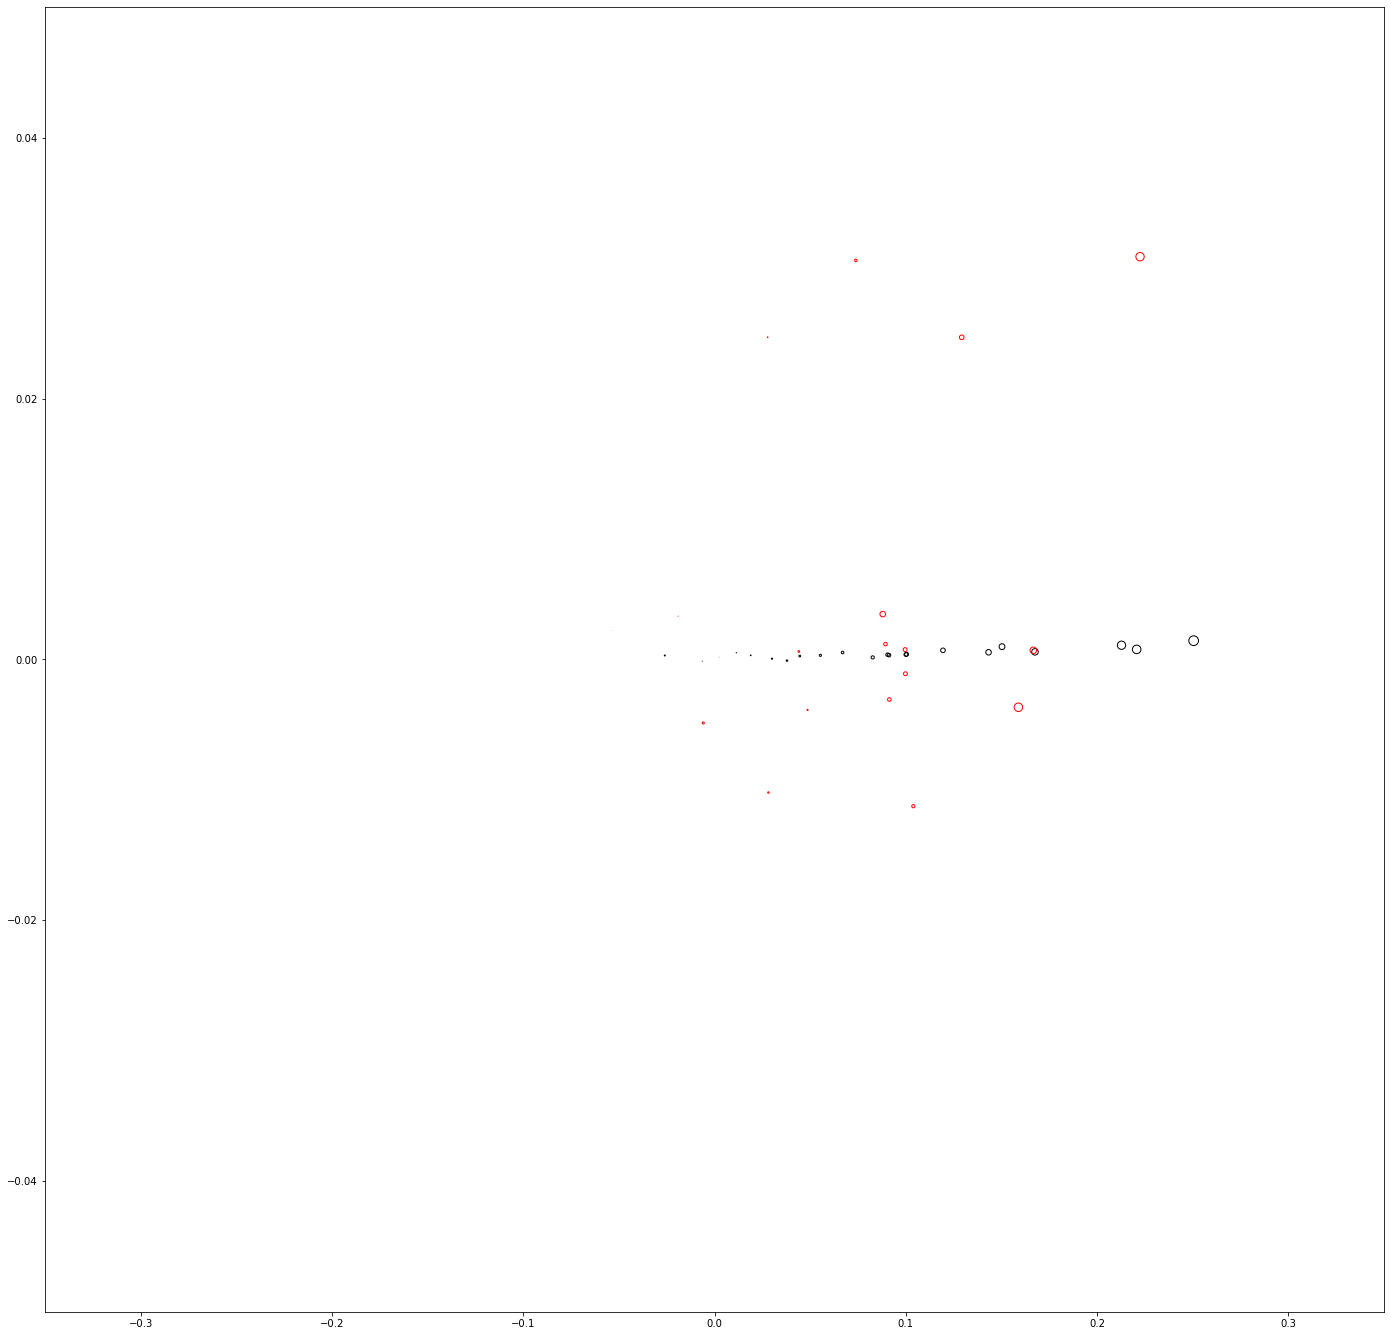

In [16]:
match_1_r = match_ghosts(data_frame_1, data_frame_r)
dist_1_r = compute_reduced_distance(match_1_r)
print(f'distance 3d = {dist_1_r:.5f}')
dist_1_r_2d = compute_2d_reduced_distance(match_1_r)
print(f'distance 2d = {dist_1_r_2d:.5f}')
fig, ax = plotter.plot_spots([data_frame_1, data_frame_r], range_y=(-0.05, 0.05))


In [17]:
# See what happens with a random telescope
data_frame_r2, ghost_separations_r2 = simulator.full_random_telescope_sim(telescope,\
                                    max_angle=1, max_shift=0.001, beam_config=BEAM_CONFIG_1)


distance = 0.00613


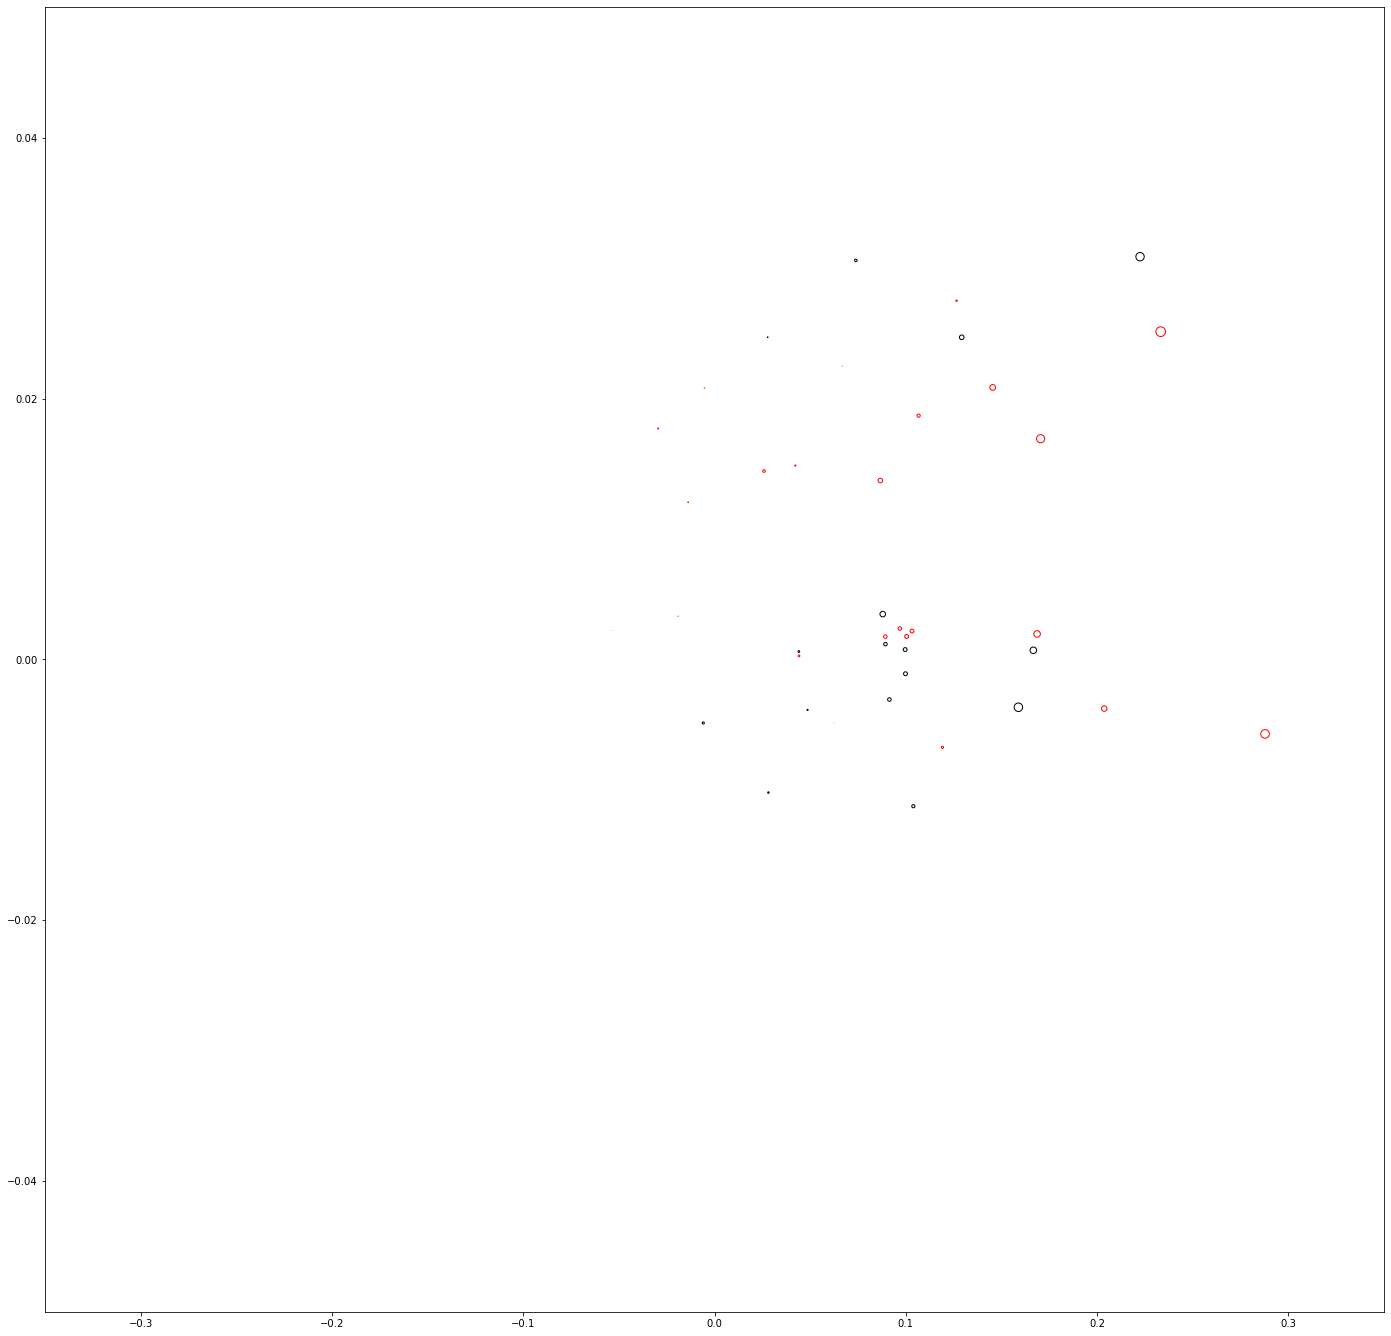

In [18]:
match_r_r2 = match_ghosts(data_frame_r, data_frame_r2)
dist_r_r2 = compute_reduced_distance(match_r_r2)
print(f'distance = {dist_r_r2:.5f}')
fig, ax = plotter.plot_spots([data_frame_r, data_frame_r2], range_y=(-0.05, 0.05))


In [19]:
match_r_r2

,beam_id_1,geom_id_1,beam_id_2,geom_id_2,ghost_1,ghost_2_2d,distance_2d,distance_2d_err,ghost_2_3d,distance_3d,distance_3d_err
0,0,0,0,0,0,0,0.000345,0.000556,0,0.000575,0.000920
1,0,0,0,0,1,14,0.002189,0.001487,13,0.031432,0.002866
2,0,0,0,0,2,5,0.011279,0.002447,12,0.025543,0.005224
3,0,0,0,0,3,6,0.028907,0.000232,6,0.041039,0.001116
4,0,0,0,0,4,9,0.018669,0.000513,8,0.039743,0.001421
5,0,0,0,0,5,5,0.002342,0.002122,5,0.002400,0.006966
6,0,0,0,0,6,6,0.043489,0.000330,6,0.043502,0.001435
7,0,0,0,0,7,7,0.039684,0.000141,7,0.039689,0.000449
8,0,0,0,0,8,16,0.010689,0.000583,18,0.040016,0.001413
9,0,0,0,0,9,8,0.010436,0.000620,19,0.022557,0.000675


In [20]:
distances_2d = list()
distances_3d = list()
for i in range(10):
    df_i, gs_i = simulator.full_random_telescope_sim(telescope,\
                         max_angle=1, max_shift=0.001, beam_config=FAST_BEAM_CONFIG_1)
    match_i = match_ghosts(data_frame_1, df_i)
    dist_i = compute_reduced_distance(match_i)
    distances_3d.append(dist_i)
    
    match_i2 = match_ghosts(data_frame_1, df_i)
    dist_i2 = compute_2d_reduced_distance(match_i2)
    distances_2d.append(dist_i2)


(array([1., 0., 1., 0., 4., 1., 1., 1., 0., 1.]),
 array([0.00127687, 0.00162438, 0.00197189, 0.0023194 , 0.00266691,
        0.00301442, 0.00336193, 0.00370944, 0.00405695, 0.00440446,
        0.00475197]),
 <BarContainer object of 10 artists>)

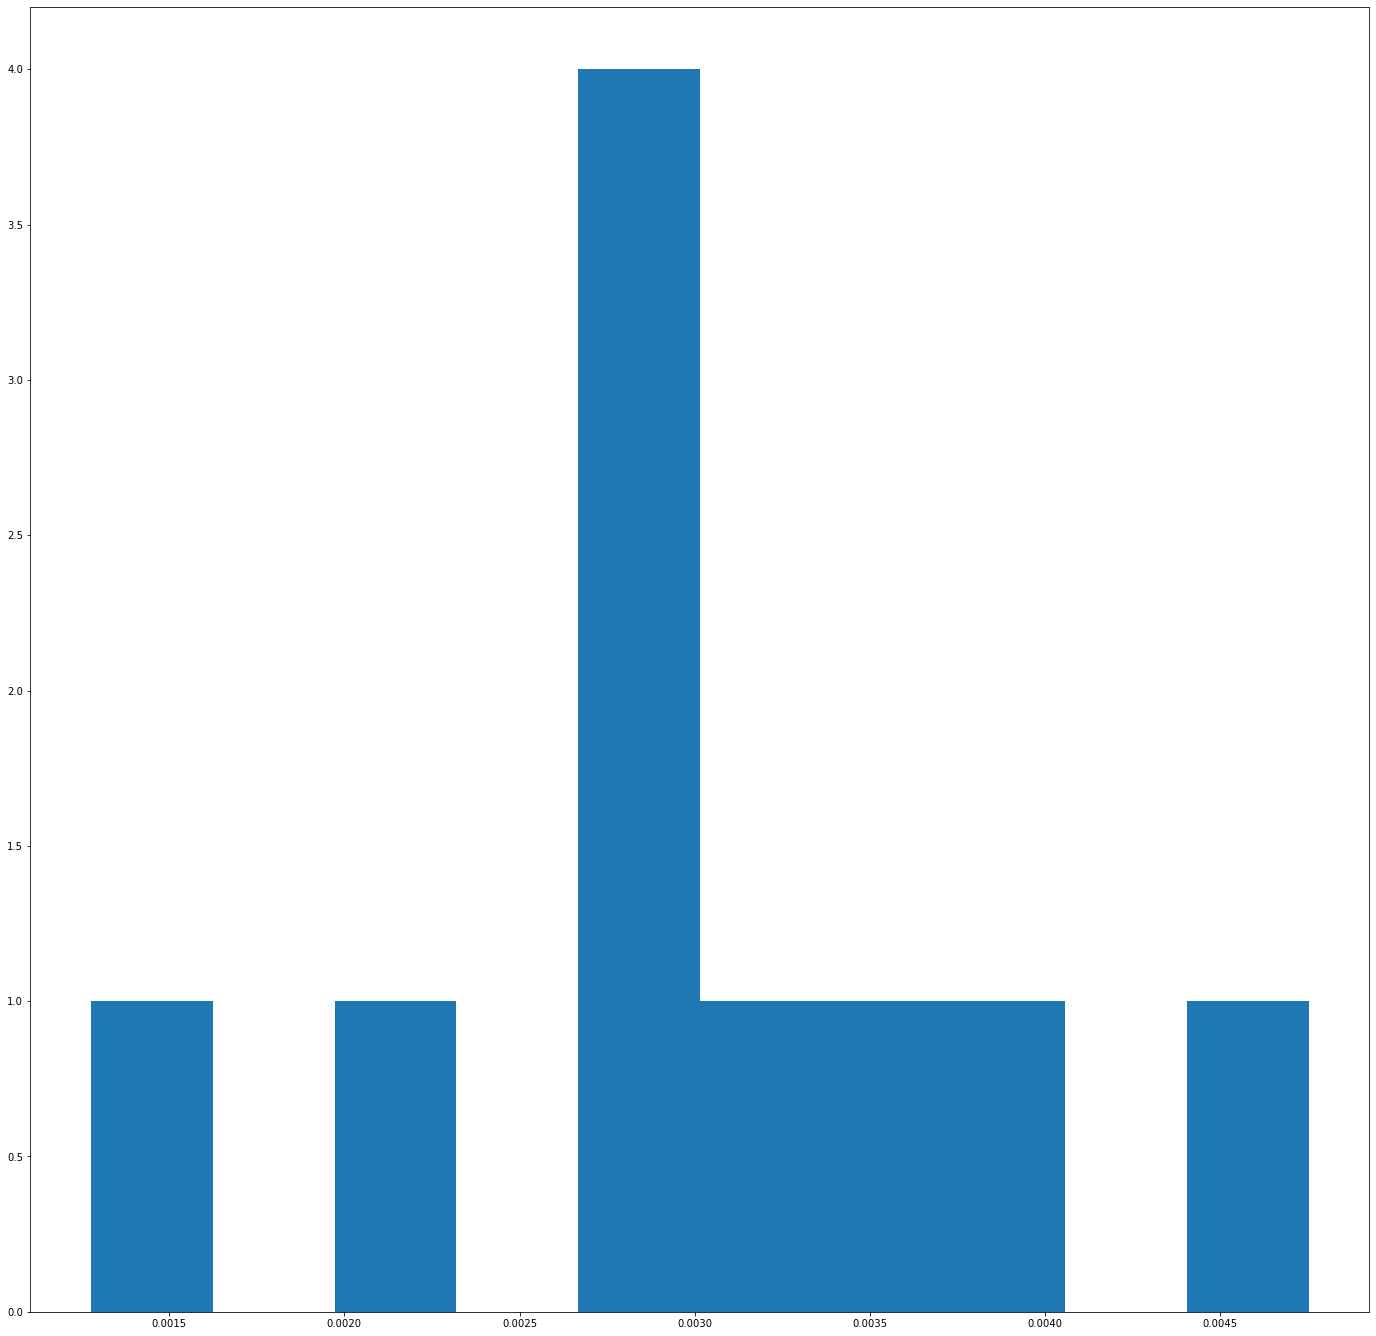

In [21]:
plt.hist(distances_2d)
# plt.xlim(0., 0.010)

(array([2., 1., 3., 1., 2., 0., 0., 0., 0., 1.]),
 array([0.00508751, 0.0058635 , 0.00663949, 0.00741548, 0.00819148,
        0.00896747, 0.00974346, 0.01051945, 0.01129544, 0.01207143,
        0.01284742]),
 <BarContainer object of 10 artists>)

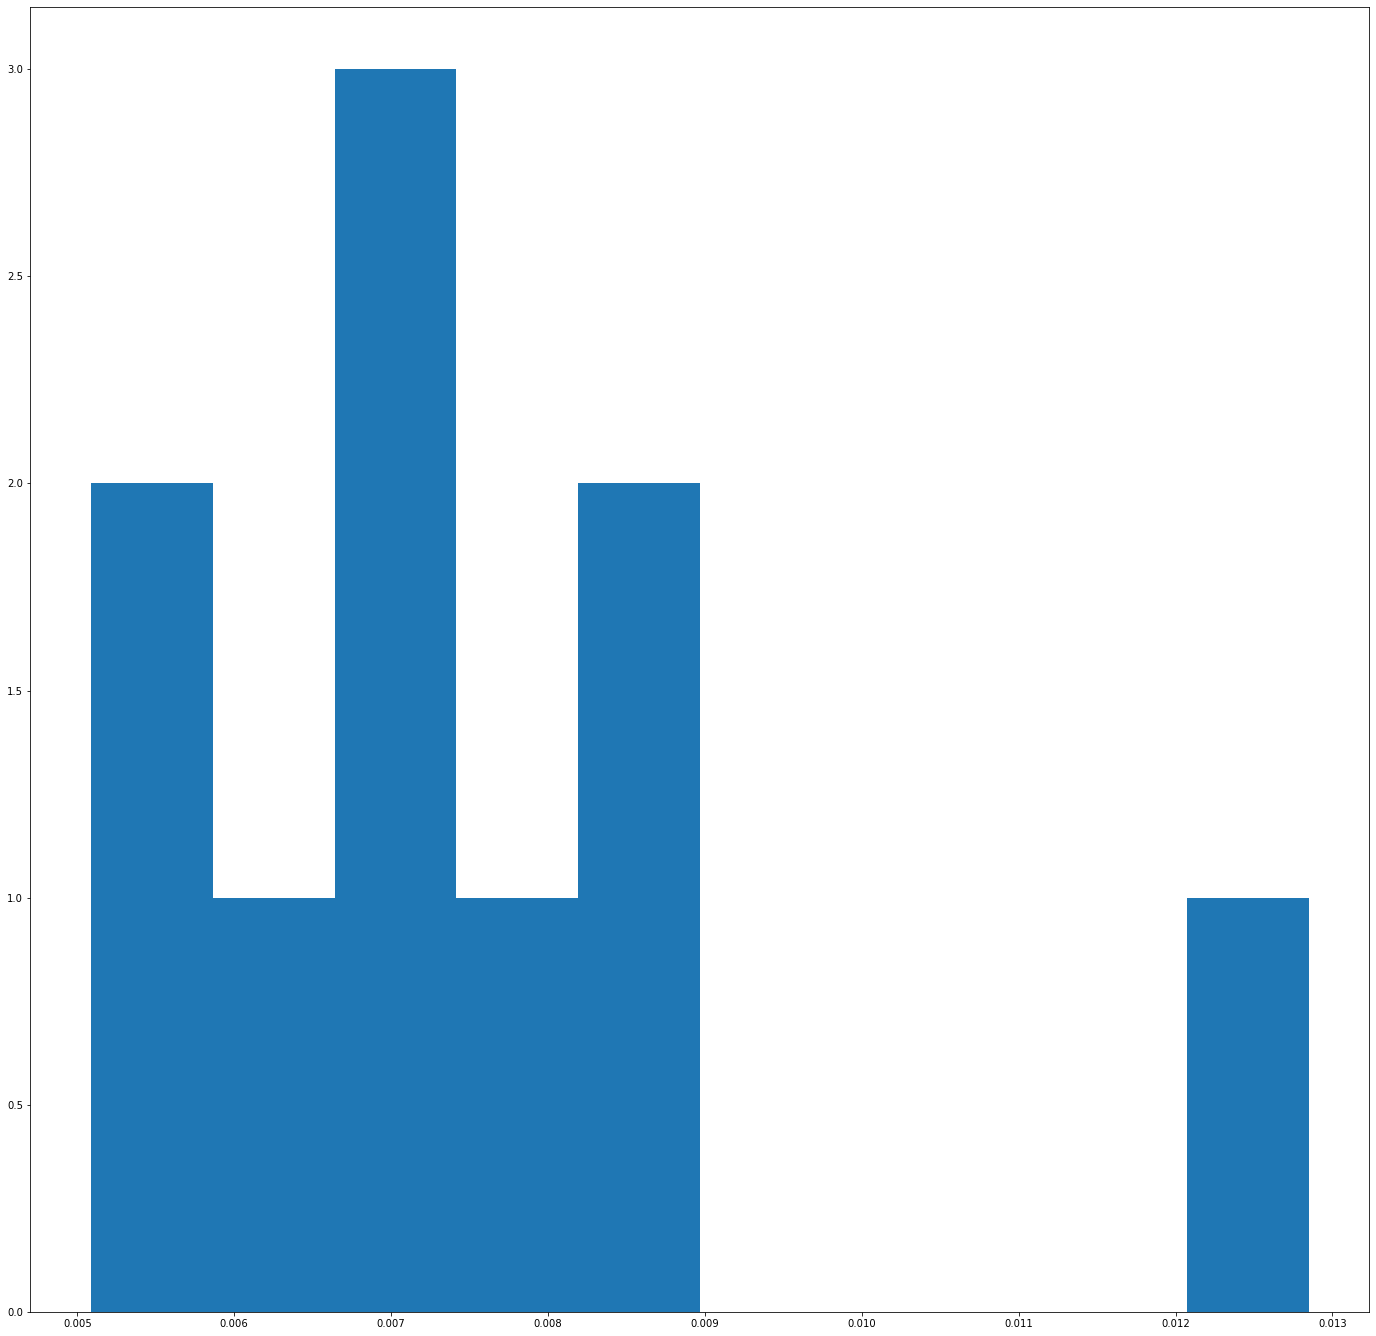

In [22]:
plt.hist(distances_3d)
